## Methods for Pre - traininig
    - Goal is to make various data that are represented in nature
    - Methods that is used are some Synthesize, Oversampling, Variational Encoder.

### CTGAN
    - 5000개 데이터 생성
    - sampling 1000개

In [11]:
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from tqdm import tqdm

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8, 6)

import warnings
warnings.filterwarnings('ignore')

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [9]:
base_path = "heg_sample_data.csv"

heg_meta = pd.read_csv(base_path)

train_data, test_data = train_test_split(
    heg_meta, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=1024, 
    stratify=heg_meta['outcome']
)

In [10]:
#test_data.to_csv("Test_data.csv", index = False)

In [12]:
N_CLS_PER_GEN = 5000

# 이상치 처리 함수
def handle_outliers(series, n_std=3):
    mean = series.mean()
    std = series.std()
    z_scores = np.abs(stats.zscore(series))
    return series.mask(z_scores > n_std, mean)

# 모든 Fraud_Type 목록 생성 (m 포함)
modality = train_data['outcome'].unique()

# 모든 합성 데이터를 저장할 DataFrame 초기화
all_synthetic_data = pd.DataFrame()

N_SAMPLE = 1000

for classes in tqdm(modality):
    
    # classes가 0이면 합성 데이터 생성 건너뛰기
    if classes == 0:
        print(f"Skipping synthetic data generation for class {classes}")
        continue

    # 해당 Fraud_Type에 대한 서브셋 생성
    subset = train_data[train_data["outcome"] == classes]

    # 모든 Fraud_Type에 대해 1000개씩 샘플링
    subset = subset.sample(n=N_SAMPLE, random_state=42)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()

    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    column_sdtypes = {
        "Unnamed: 0": "id",
        "days_from_entrance": "numerical",
        "age": "numerical",
        "document.sexo": "categorical",
        "UTI": "categorical",
        "delta_collect_timestamp_t-t1": "numerical",
        "delta_collect_timestamp_t1-t2": "numerical",
        "delta_collect_timestamp_t2-t3": "numerical",
        "delta_collect_timestamp_t3-t4": "numerical",
        "document.freq_cardiaca(t)": "numerical",
        "document.freq_cardiaca(t-1)": "numerical",
        "document.freq_cardiaca(t-2)": "numerical",
        "document.freq_cardiaca(t-3)": "numerical",
        "document.freq_cardiaca(t-4)": "numerical",
        "document.freq_respiratoria(t)": "numerical",
        "document.freq_respiratoria(t-1)": "numerical",
        "document.freq_respiratoria(t-2)": "numerical",
        "document.freq_respiratoria(t-3)": "numerical",
        "document.freq_respiratoria(t-4)": "numerical",
        "document.glicemia_capilar(t)": "numerical",
        "document.glicemia_capilar(t-1)": "numerical",
        "document.glicemia_capilar(t-2)": "numerical",
        "document.glicemia_capilar(t-3)": "numerical",
        "document.glicemia_capilar(t-4)": "numerical",
        "document.pa_diastolica(t)": "numerical",
        "document.pa_diastolica(t-1)": "numerical",
        "document.pa_diastolica(t-2)": "numerical",
        "document.pa_diastolica(t-3)": "numerical",
        "document.pa_diastolica(t-4)": "numerical",
        "document.pa_sistolica(t)": "numerical",
        "document.pa_sistolica(t-1)": "numerical",
        "document.pa_sistolica(t-2)": "numerical",
        "document.pa_sistolica(t-3)": "numerical",
        "document.pa_sistolica(t-4)": "numerical",
        "document.sat_o2(t)": "numerical",
        "document.sat_o2(t-1)": "numerical",
        "document.sat_o2(t-2)": "numerical",
        "document.sat_o2(t-3)": "numerical",
        "document.sat_o2(t-4)": "numerical",
        "document.temperatura(t)": "numerical",
        "document.temperatura(t-1)": "numerical",
        "document.temperatura(t-2)": "numerical",
        "document.temperatura(t-3)": "numerical",
        "document.temperatura(t-4)": "numerical",
        "delta_document.freq_cardiaca_t-t1": "numerical",
        "delta_document.freq_cardiaca_t1-t2": "numerical",
        "delta_document.freq_cardiaca_t2-t3": "numerical",
        "delta_document.freq_cardiaca_t3-t4": "numerical",
        "delta_document.freq_respiratoria_t-t1": "numerical",
        "delta_document.freq_respiratoria_t1-t2": "numerical",
        "delta_document.freq_respiratoria_t2-t3": "numerical",
        "delta_document.freq_respiratoria_t3-t4": "numerical",
        "delta_document.glicemia_capilar_t-t1": "numerical",
        "delta_document.glicemia_capilar_t1-t2": "numerical",
        "delta_document.glicemia_capilar_t2-t3": "numerical",
        "delta_document.glicemia_capilar_t3-t4": "numerical",
        "delta_document.pa_diastolica_t-t1": "numerical",
        "delta_document.pa_diastolica_t1-t2": "numerical",
        "delta_document.pa_diastolica_t2-t3": "numerical",
        "delta_document.pa_diastolica_t3-t4": "numerical",
        "delta_document.pa_sistolica_t-t1": "numerical",
        "delta_document.pa_sistolica_t1-t2": "numerical",
        "delta_document.pa_sistolica_t2-t3": "numerical",
        "delta_document.pa_sistolica_t3-t4": "numerical",
        "delta_document.sat_o2_t-t1": "numerical",
        "delta_document.sat_o2_t1-t2": "numerical",
        "delta_document.sat_o2_t2-t3": "numerical",
        "delta_document.sat_o2_t3-t4": "numerical",
        "delta_document.temperatura_t-t1": "numerical",
        "delta_document.temperatura_t1-t2": "numerical",
        "delta_document.temperatura_t2-t3": "numerical",
        "delta_document.temperatura_t3-t4": "numerical",
        "outcome": "categorical"
    }

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype
        )

    synthesizer = CTGANSynthesizer(
                            metadata,
                            epochs=500,
                        )
    synthesizer.fit(subset)

    synthetic_subset = synthesizer.sample(num_rows=N_CLS_PER_GEN)

    # 생성된 데이터를 all_synthetic_data에 추가
    all_synthetic_data = pd.concat([all_synthetic_data, synthetic_subset], ignore_index=True)

# 최종 결과 확인
print("\nFinal All Synthetic Data Shape:", all_synthetic_data.shape)
all_synthetic_data.head()


  0%|          | 0/2 [00:00<?, ?it/s]

Skipping synthetic data generation for class 0.0


100%|██████████| 2/2 [01:51<00:00, 55.73s/it]


Final All Synthetic Data Shape: (5000, 73)


,Unnamed: 0,days_from_entrance,age,document.sexo,UTI,delta_collect_timestamp_t-t1,delta_collect_timestamp_t1-t2,delta_collect_timestamp_t2-t3,delta_collect_timestamp_t3-t4,document.freq_cardiaca(t),...,delta_document.pa_sistolica_t3-t4,delta_document.sat_o2_t-t1,delta_document.sat_o2_t1-t2,delta_document.sat_o2_t2-t3,delta_document.sat_o2_t3-t4,delta_document.temperatura_t-t1,delta_document.temperatura_t1-t2,delta_document.temperatura_t2-t3,delta_document.temperatura_t3-t4,outcome
0,10837851,0.216128,1.565289,1.0,0.0,-0.473193,0.372250,0.200164,2.652411,0.483127,...,0.156194,-1.286698,-0.069882,0.766619,-2.733065,-1.343547,2.520188,0.185310,0.091198,1.0
1,15076803,0.648538,0.886432,0.0,0.0,-0.473193,8.502091,-0.026280,1.668993,-0.003756,...,-0.647391,-3.372272,-0.079626,1.001017,-1.482619,-0.053574,-0.104158,-2.362411,-0.095191,1.0
2,12594533,0.513345,1.231498,1.0,0.0,0.693482,0.047099,0.851867,1.878517,0.948746,...,-0.048829,-0.054392,0.267301,0.796397,0.065274,-0.644620,-0.145590,1.412362,4.578265,1.0
3,13683436,0.598803,0.757512,1.0,0.0,2.165002,1.264941,0.978569,3.016604,1.529602,...,0.289652,0.117765,0.478479,0.435855,-1.130810,0.389879,0.055899,0.175129,-0.197988,1.0
4,14500777,-0.317629,0.528803,1.0,0.0,8.249746,0.454266,1.226790,0.543002,-1.013281,...,-0.897588,0.033543,1.179433,0.139466,-0.170914,-0.120372,1.524387,-4.667872,0.806701,1.0


In [13]:
train_total = pd.concat([train_data, all_synthetic_data])
print(train_total['outcome'].value_counts())

outcome
0.0    9575
1.0    6346
Name: count, dtype: int64


In [14]:
#train_total.to_csv("pre_train_heg_sample.csv", index = False)

### SMOTE

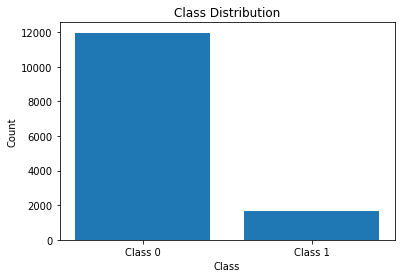

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('heg_sample_data.csv')
x=data.drop(["outcome"],axis=1)
y=data["outcome"]

count_class = y.value_counts() # Count the occurrences of each class
plt.bar(count_class.index, count_class.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(count_class.index, ['Class 0', 'Class 1'])
plt.show()

In [5]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority', random_state = 2025, k_neighbors = 3) 
x,y=smote.fit_resample(x,y)
y.value_counts()

outcome
0.0    11970
1.0    11970
Name: count, dtype: int64

In [12]:
total_dataset = pd.concat([x,y], axis = 1)

total_dataset.head()

,Unnamed: 0,days_from_entrance,age,document.sexo,UTI,delta_collect_timestamp_t-t1,delta_collect_timestamp_t1-t2,delta_collect_timestamp_t2-t3,delta_collect_timestamp_t3-t4,document.freq_cardiaca(t),...,delta_document.pa_sistolica_t3-t4,delta_document.sat_o2_t-t1,delta_document.sat_o2_t1-t2,delta_document.sat_o2_t2-t3,delta_document.sat_o2_t3-t4,delta_document.temperatura_t-t1,delta_document.temperatura_t1-t2,delta_document.temperatura_t2-t3,delta_document.temperatura_t3-t4,outcome
0,0,0.481160,-0.430375,1.0,0.0,0.181480,0.282895,0.397339,0.387741,-0.130331,...,0.107772,0.202479,0.194332,0.432788,0.012866,-0.144525,-0.024481,0.152412,0.007067,0.0
1,1,1.837695,0.230175,1.0,0.0,1.201338,1.826415,1.625187,2.170093,1.451289,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
2,2,0.226810,-0.719366,1.0,0.0,2.049497,4.031576,1.846655,2.285346,0.301020,...,0.139667,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
3,3,-0.366674,1.716413,1.0,0.0,1.038056,0.686616,1.107306,0.877358,0.684443,...,-0.101163,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
4,4,-0.366674,1.262285,0.0,0.0,0.879474,0.416499,0.427891,0.405360,0.492732,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,1.0


In [13]:
#total_dataset.to_csv("SMOTE_pre_train.csv", index = False)

### T-SMOTE